In [1]:
import numpy as np
from numpy import array
from numpy.linalg import eigvals

from Quantum_Gate_np import*

import openfermion as of
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion import get_sparse_operator
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

from scipy.optimize import minimize
import matplotlib.pyplot as plt

/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def construct_molecule_Hamiltonian(geometry, basis: str = 'sto-3g', multiplicity: int = 1, charge: int = 0, description: str = 'tmp'):

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule, run_scf = 1, run_fci = 1)

    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

    return molecule, jw_hamiltonian


def Hamiltonian_matrix_form(open_fermion_Hamiltonian, n_qubit):

    operator_map = {'X': X, 'Y': Y, 'Z': Z, 'Id2': Id2}
    Hamiltonian = 0

    for operator, coeff in open_fermion_Hamiltonian.terms.items():
        
        operator_dict = dict(operator)
        
        for i in range(n_qubit):  
            
            if i not in operator_dict:
                operator_dict = operator_dict|{i: Id2}
            else:
                operator_dict[i] = operator_map[operator_dict[i]]

        operator_dict = dict(sorted(operator_dict.items()))
        operator_matrix_rep = operator_dict.values()
        operator_matrix_rep = reduce(kron, operator_matrix_rep)
        operator_matrix_rep = coeff * operator_matrix_rep
        
        Hamiltonian += operator_matrix_rep 

    return Hamiltonian

In [3]:
# Ansatz circuit
def constructUfromTheta(n_qubit, depth, theta_list, control_gate_memory = None):
    
    gate_list = []

    gate_matrix = RY(theta = theta_list[-2])
    gate = QuantumGate(n = n_qubit, free_bits_dict={0: gate_matrix}, target_bits_dict={}, controlled_bits_dict={})
    gate_list.append(gate)

    gate_matrix = RZ(theta = theta_list[-1])
    gate = QuantumGate(n = n_qubit, free_bits_dict={0: gate_matrix}, target_bits_dict={}, controlled_bits_dict={})
    gate_list.append(gate)
    

    for d in range(depth):
        for i in range(n_qubit):
            gate_matrix = RZ(theta = theta_list[2 * i + 1 + 2 * n_qubit * d]) @ RY(theta = theta_list[2 * i + 2 * n_qubit * d])
            gate = QuantumGate(n = n_qubit, free_bits_dict={i: gate_matrix}, target_bits_dict={}, controlled_bits_dict={})
            gate_list.append(gate)

        for i in range(n_qubit//2):
            if control_gate_memory is None:
                gate = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+1: Z}, controlled_bits_dict={2*i: 1})
            else:
                key = (2 * i + 1, 'Z', 2 * i,  1)
                if key in control_gate_memory:
                    gate = control_gate_memory[key]
                else:
                    control_gate_memory[key] = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+1: Z}, controlled_bits_dict={2*i: 1})
                    gate = control_gate_memory[key]

            gate_list.append(gate)

        for i in range(n_qubit//2 - 1):
            if control_gate_memory is None:
                gate = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+2: Z}, controlled_bits_dict={2*i+1: 1})
            else:
                key = (2 * i + 2, 'Z', 2 * i + 1,  1)
                if key in control_gate_memory:
                    gate = control_gate_memory[key]
                else:
                    control_gate_memory[key] = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+2: Z}, controlled_bits_dict={2*i+1: 1})
                    gate = control_gate_memory[key]
            
            gate_list.append(gate)

    for i in range(n_qubit):
        gate_matrix = RZ(theta = theta_list[2 * i + 1 + 2 * n_qubit * depth]) @ RY(theta = theta_list[2 * i + 2 * n_qubit * depth])
        gate_list.append(gate)
    
    circuit = reduce(lambda m1, m2: m1 @ m2, map(lambda m1: m1.matrix_rep, reversed(gate_list)))

    return circuit


def H_Exp(Hamiltonian: array, n_qubit: int, depth: int, theta_list: array, in_state: array, control_gate_memory = None):
    

    circuit = constructUfromTheta(n_qubit = n_qubit, depth = depth, theta_list=theta_list, control_gate_memory=control_gate_memory)
    
    out_state = circuit @ in_state
    
    H_exptation = out_state.conjugate().T @ Hamiltonian @ out_state

    return H_exptation[0, 0].real



def H_Exp_2(Hamiltonian: array, n_qubit: int, depth: int, theta_list: array, diag_entry: array, control_gate_memory = None):
    
    projection = np.diag(diag_entry)

    circuit = constructUfromTheta(n_qubit = n_qubit, depth = depth, theta_list=theta_list, control_gate_memory=control_gate_memory)

    H_exptation = circuit.conjugate().T @ Hamiltonian @ circuit
    H_exptation = H_exptation @ projection
    H_exptation = H_exptation.trace()

    return H_exptation.real



## $H_2$ VQE

In [23]:
distance  = 0.977
geometry = [["H", [0, 0, 0]], ["H", [0, 0, distance]]]

molecule, Hamiltonian = construct_molecule_Hamiltonian(geometry = geometry)
n_qubit = molecule.n_qubits
Hamiltonian = Hamiltonian_matrix_form(Hamiltonian, n_qubit)

depth = 5

In [24]:
control_gate_memory = {}
theta_list = np.random.random(2 * n_qubit * (depth + 1)) * 1e-1
in_state_0 = generate_basis(n_qubit)[0].matrix_rep
cost = lambda theta_list: H_Exp(Hamiltonian=Hamiltonian, n_qubit = n_qubit, depth = depth, theta_list=theta_list, in_state=in_state_0, control_gate_memory = control_gate_memory)
cost_history = []
options = {"disp": True}
#N_call = 0
res = minimize(fun = cost, x0 = theta_list, method = "BFGS", callback = lambda x: cost_history.append(cost(x)), options = options)

Optimization terminated successfully.
         Current function value: -1.105933
         Iterations: 138
         Function evaluations: 7497
         Gradient evaluations: 153


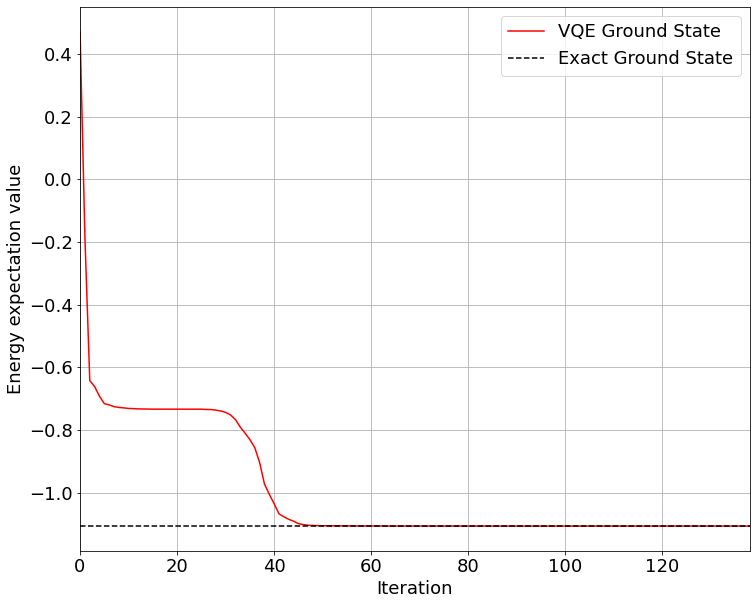

In [25]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = (12, 10)

E_initial = H_Exp(Hamiltonian=Hamiltonian, n_qubit=n_qubit, depth=depth, theta_list=theta_list, in_state=in_state_0)
plt.plot([E_initial.real] + cost_history, color="red", label="VQE Ground State")
plt.plot(range(len(cost_history) + 2), [molecule.fci_energy]*(len(cost_history)+2), linestyle="dashed", color="black", label="Exact Ground State")


plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.xlim(0, len(cost_history))
plt.legend()
plt.grid()
plt.show()

In [38]:
in_state_0_1 = generate_basis(n_qubit)[1].matrix_rep
theta_list = np.random.random(2 * n_qubit * (depth + 1)) * 1e-1
cost_1 = lambda theta_list: H_Exp_2(Hamiltonian=Hamiltonian, n_qubit = n_qubit, depth = depth, theta_list=theta_list, diag_entry = array([1, 0.7] + [0]*14), control_gate_memory = control_gate_memory)
H_hist = []

def call_back(theta_list):
    
    circuit = constructUfromTheta(n_qubit = n_qubit, depth = depth, theta_list=theta_list, control_gate_memory=control_gate_memory)
    UHU = circuit.conjugate().T @ Hamiltonian @ circuit
    H_hist.append(np.diag(UHU)[0: 2].real)    
    

res_1 = minimize(fun = cost_1, x0 = theta_list, method = "BFGS", callback = call_back, options = options)

H_hist = array(H_hist)
H_hist = H_hist[:, H_hist[-1].argsort()].T

Optimization terminated successfully.
         Current function value: -1.619023
         Iterations: 67
         Function evaluations: 3528
         Gradient evaluations: 72


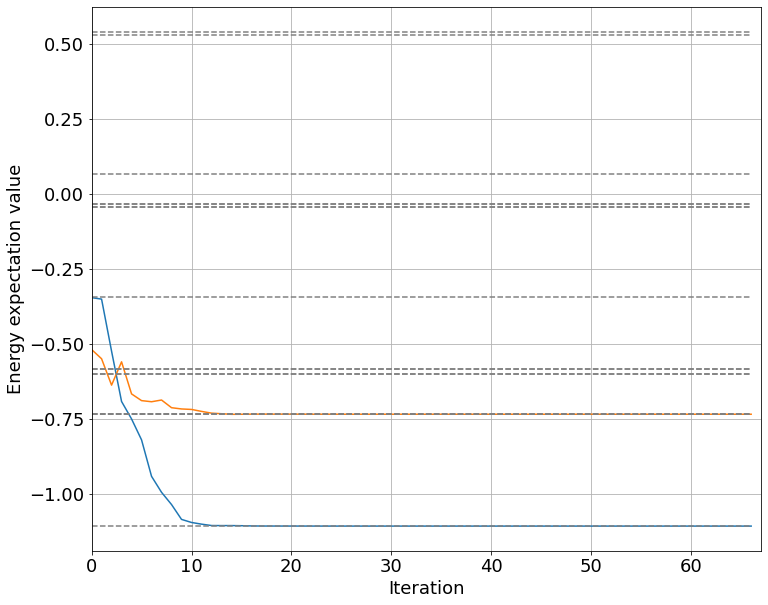

In [39]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = (12, 10)

# plt.plot(H0_hist, color="red", label="VQE Ground State")
# plt.plot(H1_hist, color="blue", label="VQE 1st Excited")
# plt.plot(H2_hist, color="green", label="VQE 1st Excited")

for i, E in enumerate(sorted(eigvals(Hamiltonian).real)):
    
    if i < H_hist.shape[0]:
        plt.plot(H_hist[i])

    plt.plot(range(H_hist.shape[1]), [E] * H_hist.shape[1], linestyle="dashed", color="grey")

plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.xlim(0, H_hist.shape[1])
# plt.legend()
plt.grid()
plt.show()

## Fermi-Hubbard

In [56]:
nsites = 2
U = 3.0
J = 1.0 * 87

hubbard = of.fermi_hubbard(x_dimension=nsites, y_dimension=1, tunneling=-J, coulomb=U, periodic=False)
hubbard = jordan_wigner(hubbard)
n_qubit_hf = 4
hubbard_matrix_form = Hamiltonian_matrix_form(hubbard, n_qubit_hf)

In [ ]:
reduce(kron, [Id2, Id2, Id2, Id2]) + 0.5*(reduce(kron, [Z, Id2, Z, Id2]) + reduce(kron, [Id2, Z, Id2, Z]))

In [57]:
sorted(eigvals(hubbard_matrix_form).real)

[-172.50646539712255,
 -86.99999999999997,
 -86.99999999999997,
 -84.00000000000006,
 -84.0,
 0.0,
 0.0,
 0.0,
 1.0405657449064616e-15,
 3.0000000000000004,
 6.0,
 86.99999999999993,
 86.99999999999994,
 90.00000000000001,
 90.00000000000001,
 175.50646539712258]

In [39]:
control_gate_memory_hf = {}
theta_list_hf = np.random.random(2 * n_qubit_hf * (depth + 1)) * 1e-1
in_state_0_hf = generate_basis(n_qubit_hf)[0].matrix_rep
cost_hf = lambda theta_list: H_Exp(Hamiltonian = hubbard_matrix_form, n_qubit = n_qubit_hf, depth = depth, theta_list=theta_list, in_state=in_state_0_hf, control_gate_memory=control_gate_memory_hf)
cost_history_hf = []
options = {"disp": True}
#N_call = 0
res_hf = minimize(fun = cost_hf, x0 = theta_list_hf, method = "BFGS", callback = lambda x: cost_history_hf.append(cost_hf(x)), options = options)

Optimization terminated successfully.
         Current function value: -2.014904
         Iterations: 78
         Function evaluations: 6966
         Gradient evaluations: 86


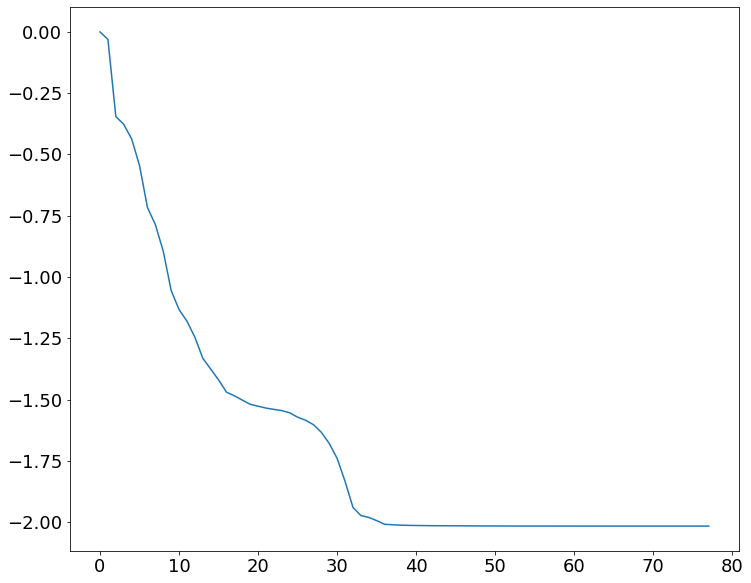

In [40]:
plt.plot(cost_history_hf)
plt.show()

In [43]:
theta_list_hf_2 = np.random.random(2 * n_qubit_hf * (depth + 1)) * 1e-1
cost_history_hf_2 = []
options = {"disp": True}
res_hf_2 = minimize(fun = cost_hf, x0 = theta_list_hf_2, method = "BFGS", callback = lambda x: cost_history_hf_2.append(cost_hf(x)), options = options)

Optimization terminated successfully.
         Current function value: -2.000000
         Iterations: 144
         Function evaluations: 12474
         Gradient evaluations: 154


In [54]:
theta_list_hf_3 = np.random.random(2 * n_qubit_hf * (depth + 1)) * 1e-1
cost_history_hf_3 = []
options = {"disp": True}
res_hf_3 = minimize(fun = cost_hf, x0 = theta_list_hf_3, method = "BFGS", callback = lambda x: cost_history_hf_3.append(cost_hf(x)), options = options)

Optimization terminated successfully.
         Current function value: -2.000000
         Iterations: 132
         Function evaluations: 11259
         Gradient evaluations: 139


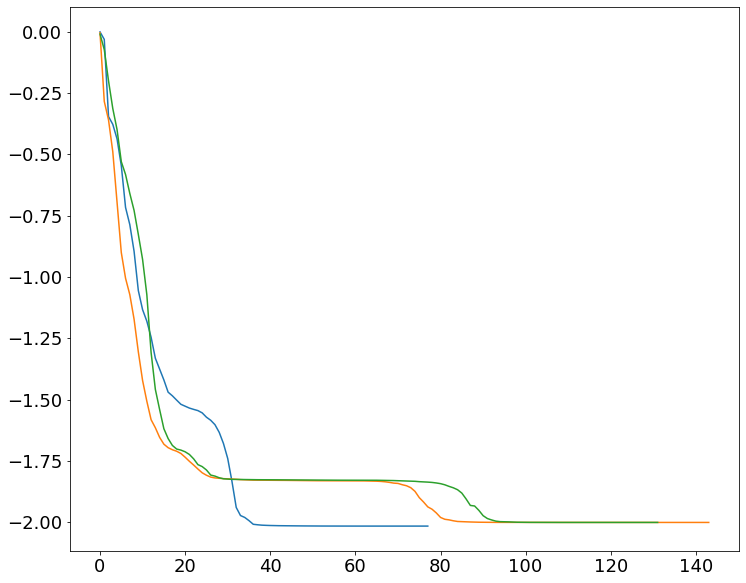

In [55]:
plt.plot(cost_history_hf)
plt.plot(cost_history_hf_2)
plt.plot(cost_history_hf_3)
plt.show()

In [50]:
len(sorted(eigvals(Hamiltonian_matrix_form(hubbard, 8)).real))

256

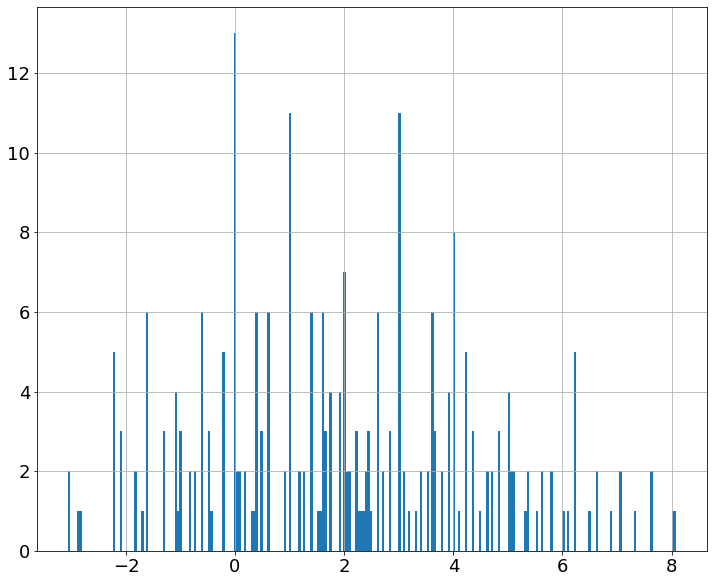

In [84]:
plt.hist(sorted(eigvals(Hamiltonian_matrix_form(hubbard, 8)).real), bins=256)
plt.grid()
plt.show()

In [48]:
array([12., 20., 38., 40., 42., 36., 31., 19., 11.,  7.]).sum()

256.0